## Klasifikasi Diabetes

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, Dict, Any, List

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [30]:
# Set random seed untuk reproduksibilitas
np.random.seed(42)

Diabetes merupakan penyakit kronis yang ditandai dengan kadar gula darah tinggi.
Menurut WHO, jumlah penderita diabetes di seluruh dunia terus meningkat dan mencapai
422 juta orang pada tahun 2014, dari 108 juta di tahun 1980.

Deteksi dini dan diagnosis yang akurat menjadi kunci penting dalam penanganan diabetes.
Dengan mengembangkan model prediktif berbasis machine learning, diharapkan kita dapat
mengidentifikasi individu yang berisiko terkena diabetes berdasarkan faktor-faktor medis
dan gaya hidup, sehingga tindakan pencegahan dapat dilakukan lebih awal.

## Problem Statements:
1. Bagaimana mengembangkan model machine learning yang dapat memprediksi risiko diabetes pada individu?
2. Faktor atau variabel apa yang paling berpengaruh dalam memprediksi risiko diabetes?
3. Bagaimana performa model dalam memprediksi risiko diabetes berdasarkan metrik evaluasi?

Goals:
1. Mengembangkan model klasifikasi untuk memprediksi risiko diabetes
2. Mengidentifikasi faktor-faktor utama (feature importance) yang berpengaruh pada risiko diabetes.
3. Menghasilkan model yang memiliki keseimbangan baik antara sensitivitas (recall) dan presisi.

In [31]:
# Import dataset diabetes (Pima Indians Diabetes Database)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

df = pd.read_csv(url, names=column_names)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
df.shape

(768, 9)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [34]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [35]:
df.corr()['Outcome'].sort_values()

,Outcome
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
DiabetesPedigreeFunction,0.173844
Pregnancies,0.221898
Age,0.238356
BMI,0.292695
Glucose,0.466581
Outcome,1.000000


## Korelasi
- Pregnancies:	Lebih banyak kehamilan → stres metabolik yang lebih besar, risiko lebih tinggi.
- Glucose: Gula darah merupakan indikator terkuat diabetes.
- BloodPressure:	Hipertensi sering terjadi bersamaan dengan diabetes (sindrom metabolik)
- SkinThickness:	Nilai yang lebih tinggi dapat menandakan resistensi insulin.
- Insulin:	Variabel yang dapat digunakan untuk mendeteksi resistansi
- BMI:	Nilai BMI berlebih bisa saja mengindikasikan orang tersebut obesitas, yang merupakan faktor utama diabetes
- DiabetesPedigreeFunction:	Riwayat keluarga resiko diabetes
- Age: Resiko meningkat seiring berjalannya usia

In [36]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [37]:
# Memeriksa nilai 0 pada kolom yang seharusnya tidak bernilai 0
zero_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for column in zero_columns:
    zero_count = (df[column] == 0).sum()
    print(f"Jumlah nilai 0 pada kolom {column}: {zero_count} ({zero_count/len(df)*100:.2f}%)")

Jumlah nilai 0 pada kolom Glucose: 5 (0.65%)
Jumlah nilai 0 pada kolom BloodPressure: 35 (4.56%)
Jumlah nilai 0 pada kolom SkinThickness: 227 (29.56%)
Jumlah nilai 0 pada kolom Insulin: 374 (48.70%)
Jumlah nilai 0 pada kolom BMI: 11 (1.43%)


- Glucose: Tidak mungkin 0 mg/dL (missing value)
- BloodPressure: Tidak mungkin 0 mmHg (missing value)
- SkinThickness: Kemungkinan tidak dilakukan pengukuran (missing value)
- Insulin: Bisa saja tidak dilakukan pengukuran (missing value)
- BMI: Tidak mungkin 0 kg/m²


## EDA

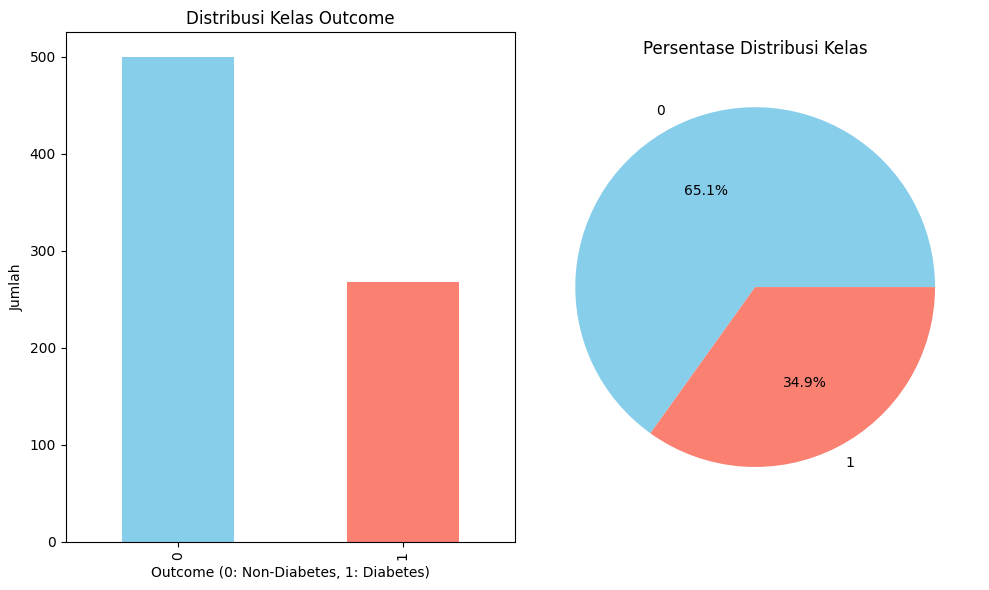

In [38]:
# Distribusi variabel target
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Kelas Outcome')
plt.xlabel('Outcome (0: Non-Diabetes, 1: Diabetes)')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
df['Outcome'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Persentase Distribusi Kelas')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [39]:
print(f"\nDistribusi kelas target (Outcome):")
print(df["Outcome"].value_counts())
print(f"Persentase kelas 1 (Diabetes): {df['Outcome'].mean()*100:.2f}%")
print(f"Persentase kelas 0 (Non-Diabetes): {(1-df['Outcome'].mean())*100:.2f}%")


Distribusi kelas target (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64
Persentase kelas 1 (Diabetes): 34.90%
Persentase kelas 0 (Non-Diabetes): 65.10%


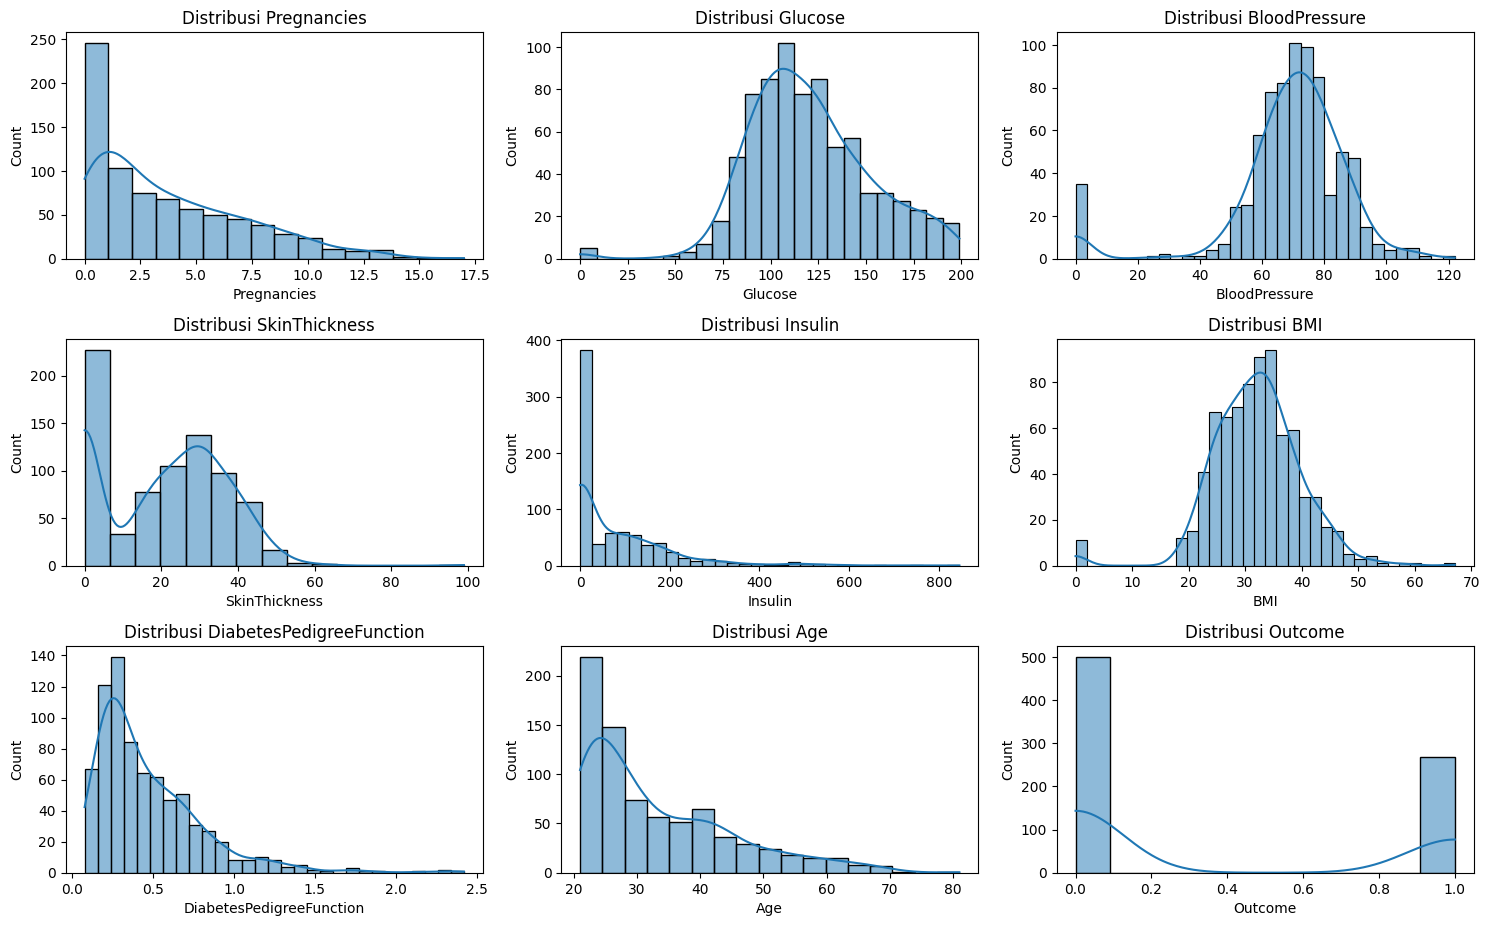

In [40]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns):  # Include all columns
    plt.subplot(4, 3, i+1)  # 4x3 grid gives 12 spots (more than enough)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribusi {column}')
    plt.tight_layout()
plt.show()

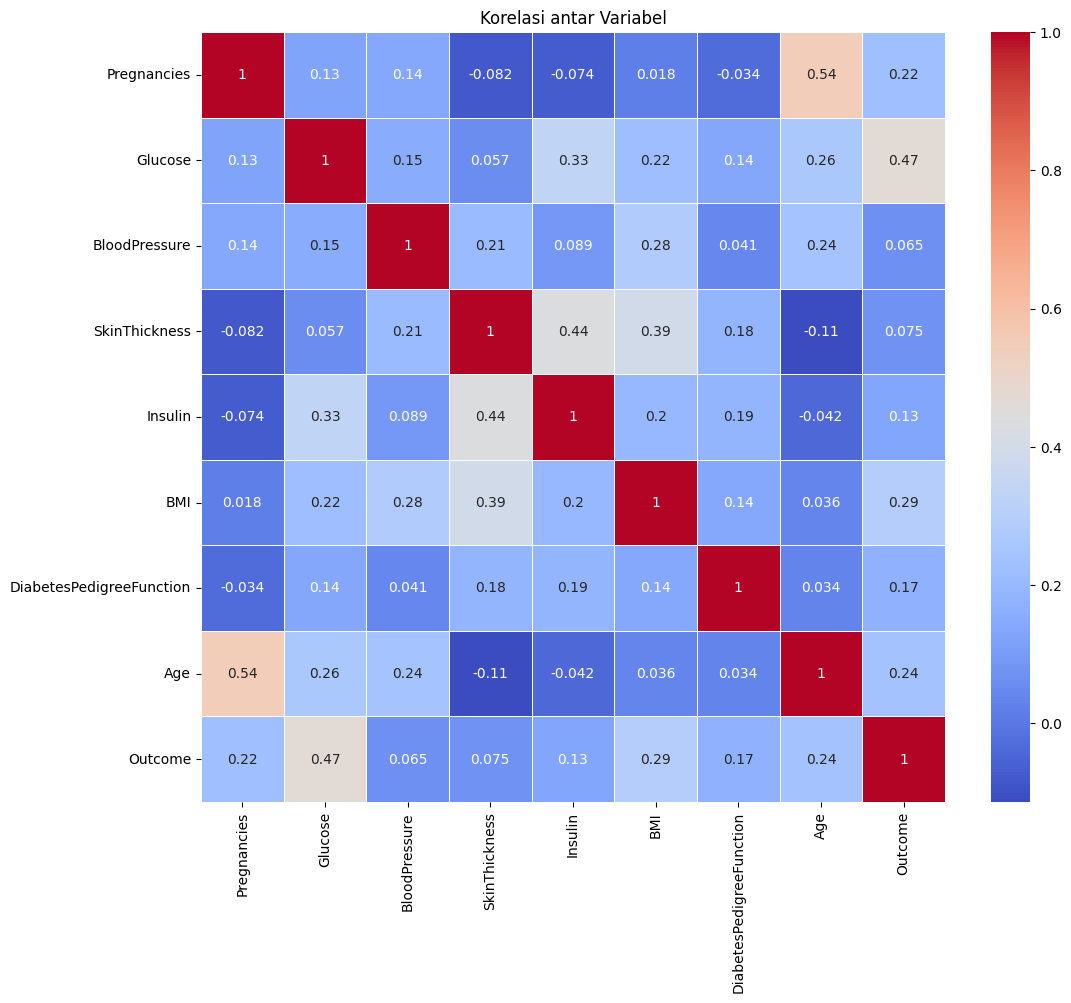

In [41]:
# Korelasi antar variabel
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korelasi antar Variabel')
plt.show()

## Data Preprocessing

In [42]:
# Membuat salinan dataframe untuk preprocessing
df_processed = df.copy()

In [43]:
# Mengganti nilai 0 dengan NaN untuk kolom tertentu
for column in zero_columns:
    df_processed[column] = df_processed[column].replace(0, np.nan)

print("Jumlah nilai yang hilang setelah mengganti nilai 0 dengan NaN:")
print(df_processed.isnull().sum())

Jumlah nilai yang hilang setelah mengganti nilai 0 dengan NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [44]:
# Menggunakan KNN Imputer untuk mengisi nilai yang hilang
imputer = KNNImputer(n_neighbors=5)
df_processed_imputed = pd.DataFrame(imputer.fit_transform(df_processed),
                                    columns=df_processed.columns)

df_processed_imputed.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


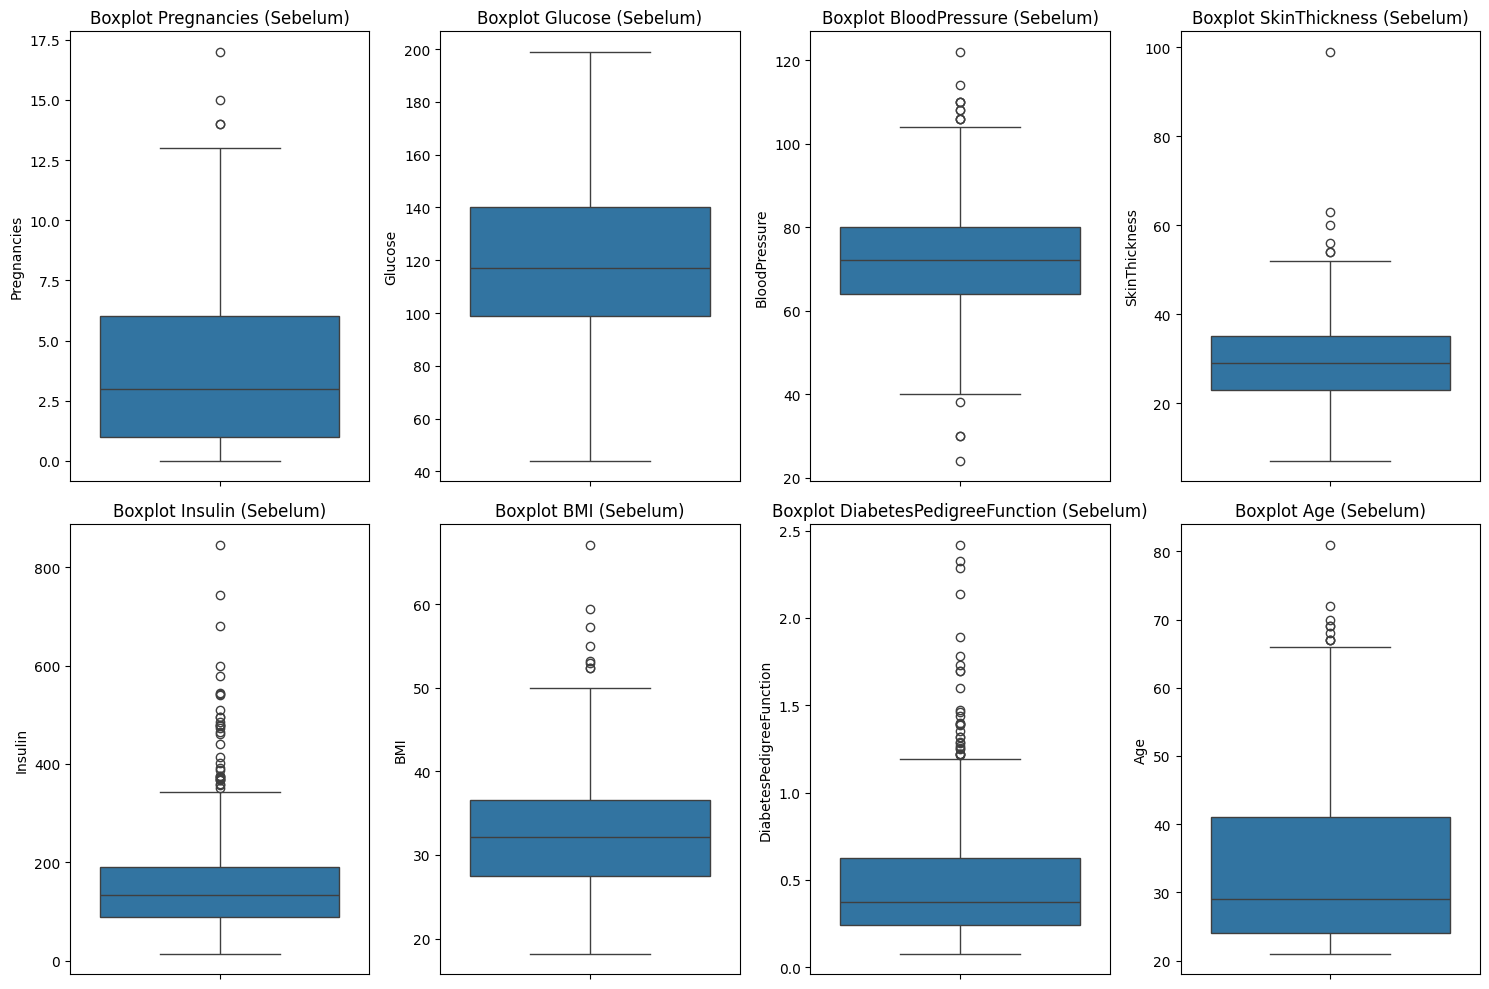

In [45]:
# Visualisasi outlier sebelum penanganan
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_processed_imputed.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df_processed_imputed[column])
    plt.title(f'Boxplot {column} (Sebelum)')
plt.tight_layout()
plt.show()

In [46]:
# Menggunakan Isolation Forest untuk mendeteksi dan menangani outlier
X = df_processed_imputed.drop('Outcome', axis=1)
y = df_processed_imputed['Outcome']

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso_forest.fit_predict(X)
outliers_mask = outlier_preds == -1

print(f"Jumlah data yang terdeteksi sebagai outlier: {sum(outliers_mask)}")
print(f"Persentase outlier: {sum(outliers_mask)/len(X)*100:.2f}%")

Jumlah data yang terdeteksi sebagai outlier: 39
Persentase outlier: 5.08%


Jumlah data setelah menghapus outlier: 729


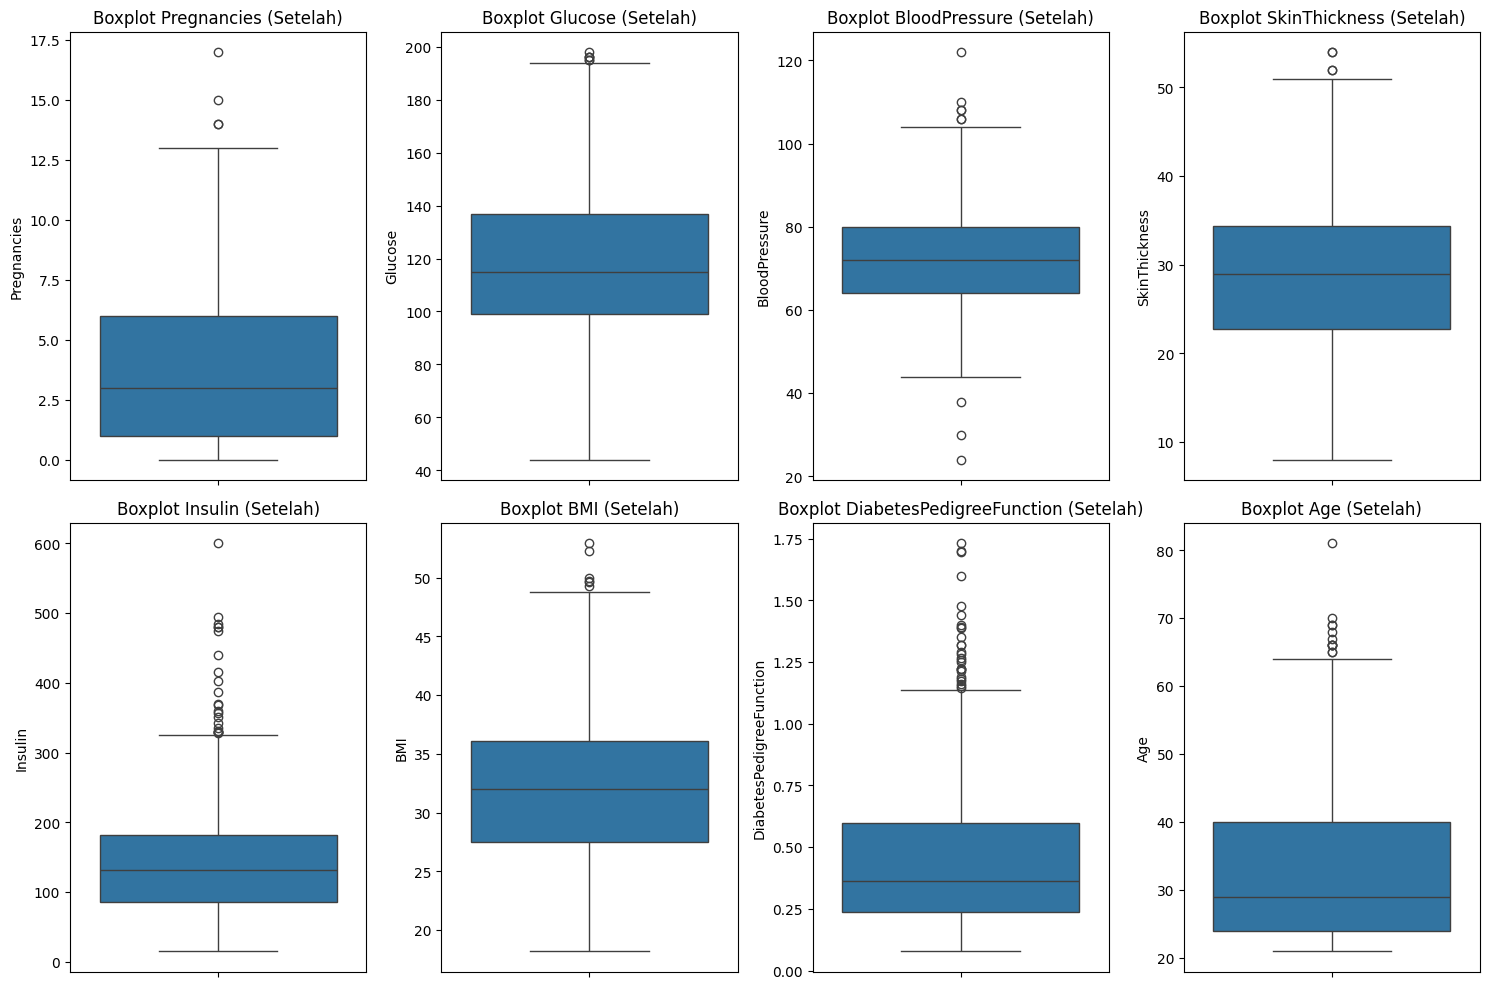

In [47]:
# Menghapus outlier
df_no_outliers = df_processed_imputed[~outliers_mask].reset_index(drop=True)
print(f"Jumlah data setelah menghapus outlier: {len(df_no_outliers)}")

# Visualisasi data setelah penanganan outlier
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_no_outliers.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df_no_outliers[column])
    plt.title(f'Boxplot {column} (Setelah)')
plt.tight_layout()
plt.show()

In [48]:
# Menerapkan StandardScaler
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(df_no_outliers.drop('Outcome', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=df_no_outliers.columns[:-1])
df_scaled['Outcome'] = df_no_outliers['Outcome'].values

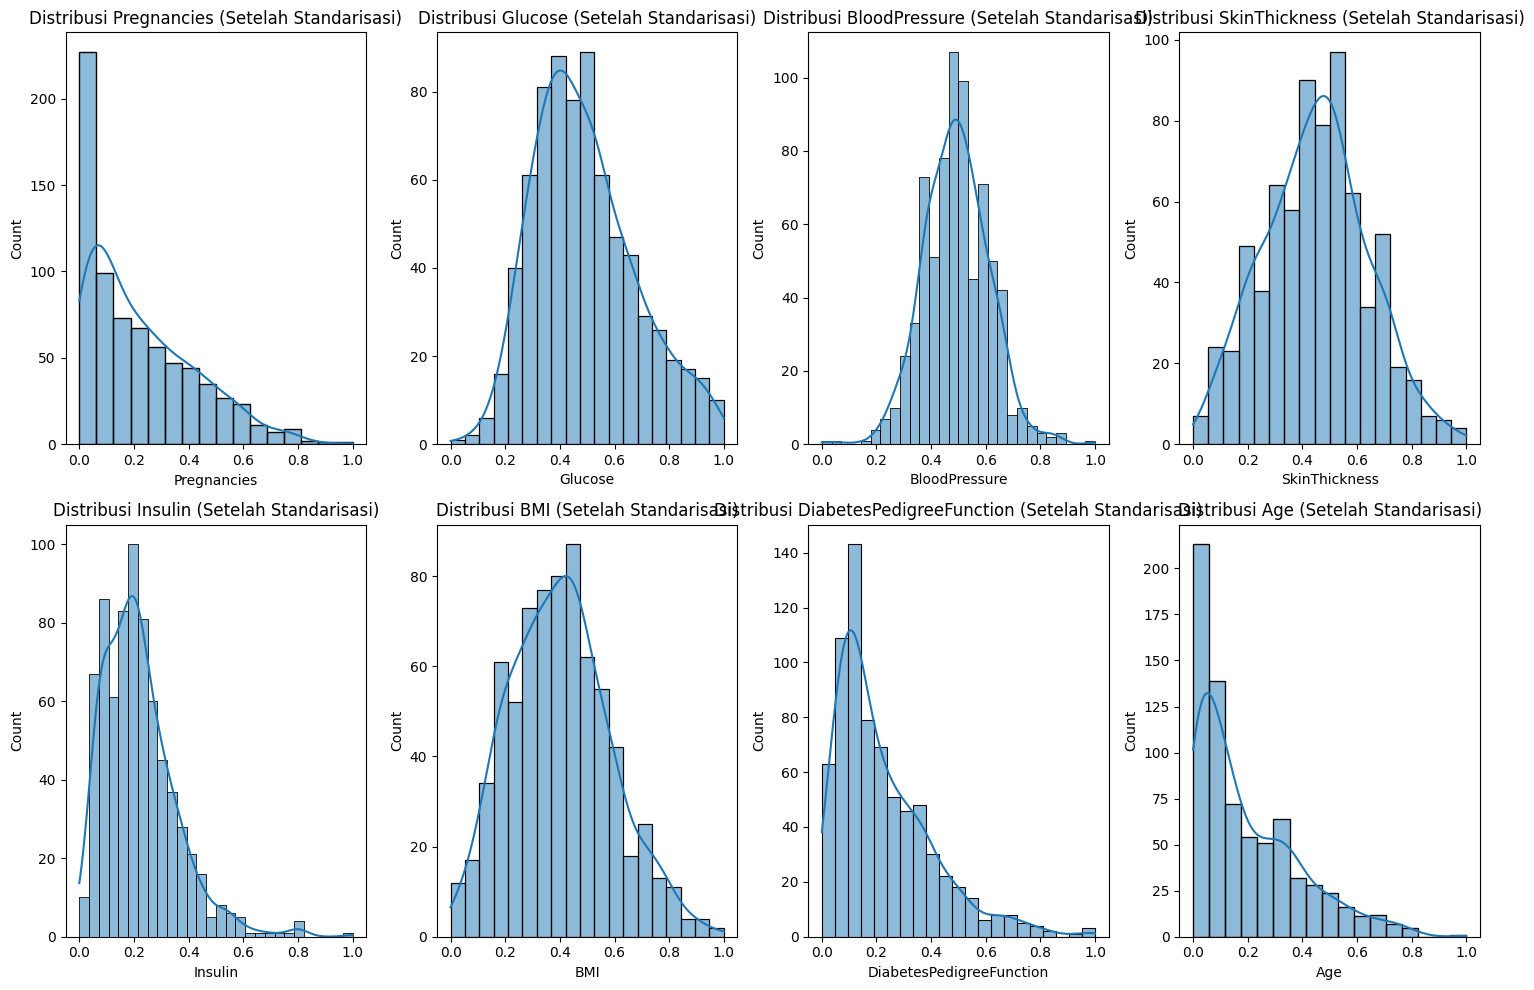

In [49]:
# Visualisasi data setelah standarisasi
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_scaled.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.histplot(df_scaled[column], kde=True)
    plt.title(f'Distribusi {column} (Setelah Standarisasi)')
plt.tight_layout()
plt.show()

## Train Model

In [52]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [53]:
class DiabetesTensorFlowClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.histories = {}
        self.best_model = None
        self.feature_names = None

    def prepare_data(self, df: pd.DataFrame, target_column: str = 'Outcome',
                    test_size: float = 0.2, validation_size: float = 0.2) -> Tuple:
        """
        Mempersiapkan data untuk training, validation, dan testing
        """
        # Memisahkan fitur dan target
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        self.feature_names = X.columns.tolist()

        # Split data menjadi train+val dan test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Split train+val menjadi train dan validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=validation_size, random_state=42, stratify=y_temp
        )

        # Normalisasi data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training samples: {X_train_scaled.shape[0]}")
        print(f"Validation samples: {X_val_scaled.shape[0]}")
        print(f"Testing samples: {X_test_scaled.shape[0]}")
        print(f"Number of features: {X_train_scaled.shape[1]}")

        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

    def create_simple_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat simple Deep Neural Network
        """
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ], name='Simple_DNN')

        return model

    def create_deep_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Deep Neural Network yang lebih kompleks
        """
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),

            layers.Dense(1, activation='sigmoid')
        ], name='Deep_DNN')

        return model

    def create_wide_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Wide Neural Network
        """
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ], name='Wide_DNN')

        return model

    def create_residual_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Neural Network dengan Residual connections
        """
        inputs = layers.Input(shape=(input_dim,))

        # First block
        x = layers.Dense(64, activation='relu')(inputs)
        x = layers.Dropout(0.3)(x)

        # Residual block 1
        residual = x
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Add()([x, residual])  # Residual connection
        x = layers.Dropout(0.2)(x)

        # Residual block 2
        residual = x
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Add()([x, residual])  # Residual connection

        # Output layers
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name='Residual_DNN')
        return model

    def compile_and_train_model(self, model: keras.Model, model_name: str,
                               X_train: np.ndarray, y_train: np.ndarray,
                               X_val: np.ndarray, y_val: np.ndarray,
                               epochs: int = 100, batch_size: int = 32) -> Dict[str, Any]:
        """
        Compile dan train model dengan callbacks
        """
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                f'best_{model_name.lower()}_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        print(f"\nTraining {model_name}...")
        print(f"Model Summary:")
        model.summary()

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        self.models[model_name] = model
        self.histories[model_name] = history

        return history

    def evaluate_model(self, model: keras.Model, model_name: str,
                      X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """
        Evaluasi model dan tampilkan metrik
        """
        # Prediksi
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()

        # Hitung metrik
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

        print(f"\n{'='*50}")
        print(f"Evaluation Results for {model_name}")
        print(f"{'='*50}")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        self.plot_confusion_matrix(y_test, y_pred, model_name)

        # ROC Curve
        self.plot_roc_curve(y_test, y_pred_proba, model_name, roc_auc)

        return metrics

    def plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray, model_name: str):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def plot_roc_curve(self, y_true: np.ndarray, y_pred_proba: np.ndarray,
                      model_name: str, roc_auc: float):
        """
        Plot ROC curve
        """
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_training_history(self, model_name: str):
        """
        Plot training history
        """
        if model_name not in self.histories:
            print(f"No history found for {model_name}")
            return

        history = self.histories[model_name]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Precision
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Recall
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.suptitle(f'Training History - {model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, model: keras.Model, X_test: np.ndarray,
                             y_test: np.ndarray) -> pd.DataFrame:
        """
        Mendapatkan feature importance menggunakan permutation importance
        """
        from sklearn.inspection import permutation_importance

        # Wrapper function untuk keras model
        def keras_predict(X):
            return model.predict(X).flatten()

        # Hitung permutation importance
        perm_importance = permutation_importance(
            keras_predict, X_test, y_test,
            n_repeats=10, random_state=42, scoring='roc_auc'
        )

        # Buat DataFrame
        feature_imp = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values(by='Importance', ascending=False)

        return feature_imp

    def plot_feature_importance(self, feature_imp: pd.DataFrame, model_name: str):
        """
        Plot feature importance
        """
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp, x='Importance', y='Feature')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Permutation Importance')
        plt.tight_layout()
        plt.show()

    def compare_models(self, all_metrics: Dict[str, Dict[str, float]]) -> pd.DataFrame:
        """
        Membandingkan performa semua model
        """
        metrics_df = pd.DataFrame(all_metrics).T
        metrics_df = metrics_df.round(4)

        print("\n" + "="*60)
        print("MODEL COMPARISON RESULTS")
        print("="*60)
        print(metrics_df)

        # Plot perbandingan
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        for i, metric in enumerate(metrics):
            row, col = i // 3, i % 3
            metrics_df[metric].plot(kind='bar', ax=axes[row, col])
            axes[row, col].set_title(f'{metric.upper()} Comparison')
            axes[row, col].set_ylabel(metric.upper())
            axes[row, col].tick_params(axis='x', rotation=45)
            axes[row, col].grid(True, alpha=0.3)

        # Remove empty subplot
        axes[1, 2].axis('off')

        plt.suptitle('Model Performance Comparison', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Find best model
        best_model_name = metrics_df['f1'].idxmax()
        self.best_model = self.models[best_model_name]

        print(f"\nBest Model: {best_model_name}")
        print(f"Best F1 Score: {metrics_df.loc[best_model_name, 'f1']:.4f}")

        return metrics_df

In [64]:


# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class DiabetesTransferLearningClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.histories = {}
        self.pretrained_models = {}
        self.best_model = None
        self.feature_names = None
        self.teacher_model = None

    def prepare_data(self, df: pd.DataFrame, target_column: str = 'Outcome',
                    test_size: float = 0.2, validation_size: float = 0.2) -> Tuple:
        """
        Prepare data for training, validation, and testing
        """
        # Separate features and target
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        self.feature_names = X.columns.tolist()

        # Split data into train+val and test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Split train+val into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=validation_size, random_state=42, stratify=y_temp
        )

        # Normalize data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training samples: {X_train_scaled.shape[0]}")
        print(f"Validation samples: {X_val_scaled.shape[0]}")
        print(f"Testing samples: {X_test_scaled.shape[0]}")
        print(f"Number of features: {X_train_scaled.shape[1]}")

        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

    def create_teacher_model(self, input_dim: int) -> keras.Model:
        """
        Create Teacher Model for Knowledge Distillation
        """
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(1, activation='sigmoid')
        ], name='Teacher_Model')

        return model

    def create_pretrained_encoder(self, input_dim: int) -> keras.Model:
        """
        Create Pre-trained Encoder for Transfer Learning
        """
        encoder = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),

            layers.Dense(32, activation='relu', name='feature_representation')
        ], name='Pretrained_Encoder')

        return encoder

    def create_feature_extractor_model(self, input_dim: int) -> keras.Model:
        """
        Create Feature Extractor Model for Fine-tuning
        """
        # Create encoder part (will be frozen)
        encoder = self.create_pretrained_encoder(input_dim)

        # Create classifier part
        inputs = layers.Input(shape=(input_dim,))
        features = encoder(inputs)

        # Add classification head
        x = layers.Dense(16, activation='relu')(features)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name='Feature_Extractor_Model')

        return model, encoder

    def create_student_model(self, input_dim: int) -> keras.Model:
        """
        Create Student Model for Knowledge Distillation
        """
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),

            layers.Dense(1, activation='sigmoid')
        ], name='Student_Model')

        return model

    def create_domain_adaptation_model(self, input_dim: int) -> keras.Model:
        """
        Create Domain Adaptation Model with Gradient Reversal Layer
        """
        inputs = layers.Input(shape=(input_dim,))

        # Shared feature extractor
        shared_features = layers.Dense(64, activation='relu')(inputs)
        shared_features = layers.BatchNormalization()(shared_features)
        shared_features = layers.Dropout(0.3)(shared_features)

        shared_features = layers.Dense(32, activation='relu')(shared_features)
        shared_features = layers.BatchNormalization()(shared_features)
        shared_features = layers.Dropout(0.2)(shared_features)

        # Task-specific classifier
        task_classifier = layers.Dense(16, activation='relu')(shared_features)
        task_classifier = layers.Dropout(0.2)(task_classifier)
        task_output = layers.Dense(1, activation='sigmoid', name='task_output')(task_classifier)

        # Domain classifier (for adversarial training)
        domain_classifier = layers.Dense(16, activation='relu')(shared_features)
        domain_classifier = layers.Dropout(0.2)(domain_classifier)
        domain_output = layers.Dense(1, activation='sigmoid', name='domain_output')(domain_classifier)

        model = keras.Model(inputs=inputs, outputs=[task_output, domain_output],
                          name='Domain_Adaptation_Model')

        return model

    def create_multi_task_model(self, input_dim: int) -> keras.Model:
        """
        Create Multi-task Learning Model
        """
        inputs = layers.Input(shape=(input_dim,))

        # Shared layers
        shared = layers.Dense(128, activation='relu')(inputs)
        shared = layers.BatchNormalization()(shared)
        shared = layers.Dropout(0.4)(shared)

        shared = layers.Dense(64, activation='relu')(shared)
        shared = layers.BatchNormalization()(shared)
        shared = layers.Dropout(0.3)(shared)

        # Task 1: Diabetes classification
        task1_branch = layers.Dense(32, activation='relu')(shared)
        task1_branch = layers.Dropout(0.2)(task1_branch)
        diabetes_output = layers.Dense(1, activation='sigmoid', name='diabetes_output')(task1_branch)

        # Task 2: Risk level prediction (auxiliary task)
        task2_branch = layers.Dense(32, activation='relu')(shared)
        task2_branch = layers.Dropout(0.2)(task2_branch)
        risk_output = layers.Dense(3, activation='softmax', name='risk_output')(task2_branch)

        model = keras.Model(inputs=inputs, outputs=[diabetes_output, risk_output],
                          name='Multi_Task_Model')

        return model

    def train_teacher_model(self, X_train: np.ndarray, y_train: np.ndarray,
                           X_val: np.ndarray, y_val: np.ndarray,
                           epochs: int = 100) -> keras.Model:
        """
        Train Teacher Model for Knowledge Distillation
        """
        print("\n" + "="*60)
        print("TRAINING TEACHER MODEL")
        print("="*60)

        teacher_model = self.create_teacher_model(X_train.shape[1])

        teacher_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
        ]

        print("Teacher Model Summary:")
        teacher_model.summary()

        history = teacher_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        self.teacher_model = teacher_model
        self.histories['Teacher_Model'] = history

        return teacher_model

    def knowledge_distillation_loss(self, y_true, y_pred_student, y_pred_teacher, temperature=3.0, alpha=0.3):
        """
        Custom loss function for Knowledge Distillation
        """
        # Hard target loss (original labels)
        hard_loss = keras.losses.binary_crossentropy(y_true, y_pred_student)

        # Soft target loss (teacher predictions)
        teacher_soft = tf.nn.sigmoid(y_pred_teacher / temperature)
        student_soft = tf.nn.sigmoid(y_pred_student / temperature)
        soft_loss = keras.losses.binary_crossentropy(teacher_soft, student_soft)

        # Combine losses
        total_loss = alpha * hard_loss + (1 - alpha) * soft_loss
        return tf.reduce_mean(total_loss)

    def train_student_with_distillation(self, X_train: np.ndarray, y_train: np.ndarray,
                                      X_val: np.ndarray, y_val: np.ndarray,
                                      teacher_model: keras.Model, epochs: int = 100) -> keras.Model:
        """
        Train Student Model with Knowledge Distillation - FIXED VERSION
        """
        print("\n" + "="*60)
        print("TRAINING STUDENT MODEL WITH KNOWLEDGE DISTILLATION")
        print("="*60)

        student_model = self.create_student_model(X_train.shape[1])

        # Compile student model for easier training
        student_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='roc_auc')]
        )


        # Create custom training class for knowledge distillation
        class KnowledgeDistillationModel(keras.Model):
            def __init__(self, student, teacher, alpha=0.3, temperature=3.0):
                super(KnowledgeDistillationModel, self).__init__()
                self.student = student
                self.teacher = teacher
                self.alpha = alpha
                self.temperature = temperature

            def call(self, inputs):
                return self.student(inputs)

            def train_step(self, data):
                x, y = data

                teacher_predictions = self.teacher(x, training=False)

                with tf.GradientTape() as tape:
                    student_predictions = self.student(x, training=True)

                    hard_loss = keras.losses.binary_crossentropy(y, student_predictions)

                    teacher_soft = tf.nn.sigmoid(teacher_predictions / self.temperature)
                    student_soft = tf.nn.sigmoid(student_predictions / self.temperature)
                    soft_loss = keras.losses.binary_crossentropy(teacher_soft, student_soft)

                    # Combined loss
                    loss = self.alpha * tf.reduce_mean(hard_loss) + (1 - self.alpha) * tf.reduce_mean(soft_loss)

                gradients = tape.gradient(loss, self.student.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

                # Support built-in metric tracking
                self.compiled_loss(y, student_predictions)  # enables `val_loss`
                self.compiled_metrics.update_state(y, student_predictions)

                return {m.name: m.result() for m in self.metrics} | {"loss": loss}


        # Create distillation model
        distillation_model = KnowledgeDistillationModel(student_model, teacher_model)
        distillation_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=["accuracy", keras.metrics.AUC(name="roc_auc")]
        )


        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
        ]

        # Train with knowledge distillation
        history = distillation_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        self.models['Student_Distillation'] = student_model
        self.histories['Student_Distillation'] = history

        return student_model

    def train_fine_tuned_model(self, X_train: np.ndarray, y_train: np.ndarray,
                              X_val: np.ndarray, y_val: np.ndarray,
                              pretrained_encoder: keras.Model = None, epochs: int = 100) -> keras.Model:
        """
        Train model with Fine-tuning approach
        """
        print("\n" + "="*60)
        print("TRAINING FINE-TUNED MODEL")
        print("="*60)

        # Create model with pretrained encoder
        model, encoder = self.create_feature_extractor_model(X_train.shape[1])

        # Phase 1: Freeze encoder, train classifier
        for layer in encoder.layers:
            layer.trainable = False

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Phase 1: Training classifier with frozen encoder")
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        ]

        history1 = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs//2,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        # Phase 2: Unfreeze encoder, fine-tune entire model
        for layer in encoder.layers:
            layer.trainable = True

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print("Phase 2: Fine-tuning entire model")
        history2 = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs//2,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        # Combine histories
        combined_history = type('History', (), {})()
        combined_history.history = {}
        for key in history1.history.keys():
            combined_history.history[key] = history1.history[key] + history2.history[key]

        self.models['Fine_Tuned'] = model
        self.histories['Fine_Tuned'] = combined_history

        return model

    def create_risk_labels(self, y: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        Create auxiliary labels for multi-task learning
        """
        # Create risk labels based on some features
        # 0: Low risk, 1: Medium risk, 2: High risk

        # Assuming: column 1 = Glucose, column 5 = BMI, column 7 = Age (Pima Indians dataset)
        glucose_high = X[:, 1] > 1.0  # Normalized glucose > 1.0
        bmi_high = X[:, 5] > 1.0  # Normalized BMI > 1.0
        age_high = X[:, 7] > 1.0  # Normalized Age > 1.0

        risk_labels = np.zeros_like(y)
        risk_labels[(glucose_high | bmi_high)] = 1  # Medium risk
        risk_labels[(glucose_high & bmi_high) | age_high] = 2  # High risk

        return risk_labels

    def train_multi_task_model(self, X_train: np.ndarray, y_train: np.ndarray,
                              X_val: np.ndarray, y_val: np.ndarray,
                              epochs: int = 100) -> keras.Model:
        """
        Train Multi-task Learning Model
        """
        print("\n" + "="*60)
        print("TRAINING MULTI-TASK MODEL")
        print("="*60)

        # Create auxiliary labels
        risk_train = self.create_risk_labels(y_train, X_train)
        risk_val = self.create_risk_labels(y_val, X_val)

        # Convert to categorical
        risk_train_cat = tf.keras.utils.to_categorical(risk_train, 3)
        risk_val_cat = tf.keras.utils.to_categorical(risk_val, 3)

        model = self.create_multi_task_model(X_train.shape[1])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'diabetes_output': 'binary_crossentropy',
                'risk_output': 'categorical_crossentropy'
            },
            loss_weights={
                'diabetes_output': 1.0,
                'risk_output': 0.5
            },
            metrics={
                'diabetes_output': ['accuracy', 'precision', 'recall'],
                'risk_output': ['accuracy']
            }
        )

        print("Multi-task Model Summary:")
        model.summary()

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
        ]

        history = model.fit(
            X_train,
            {'diabetes_output': y_train, 'risk_output': risk_train_cat},
            validation_data=(X_val, {'diabetes_output': y_val, 'risk_output': risk_val_cat}),
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        self.models['Multi_Task'] = model
        self.histories['Multi_Task'] = history

        return model

    def evaluate_model(self, model: keras.Model, model_name: str,
                      X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """
        Evaluate model and display metrics
        """
        # Predict
        if model_name == 'Multi_Task':
            predictions = model.predict(X_test)
            y_pred_proba = predictions[0] if isinstance(predictions, list) else predictions
        else:
            y_pred_proba = model.predict(X_test)

        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()

        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

        print(f"\n{'='*50}")
        print(f"Evaluation Results for {model_name}")
        print(f"{'='*50}")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        self.plot_confusion_matrix(y_test, y_pred, model_name)

        # ROC Curve
        self.plot_roc_curve(y_test, y_pred_proba, model_name, roc_auc)

        return metrics

    def plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray, model_name: str):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def plot_roc_curve(self, y_true: np.ndarray, y_pred_proba: np.ndarray,
                      model_name: str, roc_auc: float):
        """
        Plot ROC curve
        """
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_training_history(self, model_name: str):
        """
        Plot training history
        """
        if model_name not in self.histories:
            print(f"No history found for {model_name}")
            return

        history = self.histories[model_name]

        # Handle different types of histories
        if model_name == 'Multi_Task':
            self.plot_multitask_history(history)
        elif model_name == 'Student_Distillation':
            self.plot_distillation_history(history)
        else:
            self.plot_standard_history(history, model_name)

    def plot_standard_history(self, history, model_name: str):
        """
        Plot standard training history
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Precision (if available)
        if 'precision' in history.history:
            axes[1, 0].plot(history.history['precision'], label='Training Precision')
            axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
            axes[1, 0].set_title('Model Precision')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        else:
            axes[1, 0].axis('off')

        # Recall (if available)
        if 'recall' in history.history:
            axes[1, 1].plot(history.history['recall'], label='Training Recall')
            axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
            axes[1, 1].set_title('Model Recall')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        else:
            axes[1, 1].axis('off')

        plt.suptitle(f'Training History - {model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_multitask_history(self, history):
        """
        Plot multi-task training history
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        # Total Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Diabetes Task Loss
        axes[0, 1].plot(history.history.get('diabetes_output_loss', []), label='Diabetes Train Loss')
        axes[0, 1].plot(history.history.get('val_diabetes_output_loss', []), label='Diabetes Val Loss')
        axes[0, 1].set_title('Diabetes Task Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Risk Task Loss
        axes[0, 2].plot(history.history.get('risk_output_loss', []), label='Risk Train Loss')
        axes[0, 2].plot(history.history.get('val_risk_output_loss', []), label='Risk Val Loss')
        axes[0, 2].set_title('Risk Task Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        # Diabetes Accuracy
        axes[1, 0].plot(history.history.get('diabetes_output_accuracy', []), label='Diabetes Train Acc')
        axes[1, 0].plot(history.history.get('val_diabetes_output_accuracy', []), label='Diabetes Val Acc')
        axes[1, 0].set_title('Diabetes Task Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Risk Accuracy
        axes[1, 1].plot(history.history.get('risk_output_accuracy', []), label='Risk Train Acc')
        axes[1, 1].plot(history.history.get('val_risk_output_accuracy', []), label='Risk Val Acc')
        axes[1, 1].set_title('Risk Task Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Remove empty subplot
        axes[1, 2].axis('off')

        plt.suptitle('Multi-Task Training History', fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_distillation_history(self, history):
        """
        Plot distillation training history
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Loss
        axes[0].plot(history.history['loss'], label='Training Loss')
        axes[0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0].set_title('Knowledge Distillation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Knowledge Distillation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)

        plt.suptitle('Knowledge Distillation Training History', fontsize=16)
        plt.tight_layout()
        plt.show()

Training samples: 466
Validation samples: 117
Testing samples: 146
Number of features: 8

TRAINING TEACHER MODEL
Teacher Model Summary:


Model: "Teacher_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,361 (185.00 KB)

 Trainable params: 46,465 (181.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.5627 - loss: 0.8240 - precision: 0.4047 - recall: 0.4856 - val_accuracy: 0.7350 - val_loss: 0.6486 - val_precision: 0.7000 - val_recall: 0.3590 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6868 - loss: 0.6030 - precision: 0.5559 - recall: 0.5982 - val_accuracy: 0.7436 - val_loss: 0.6224 - val_precision: 0.7143 - val_recall: 0.3846 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7084 - loss: 0.5891 - precision: 0.5859 - recall: 0.6092 - val_accuracy: 0.7521 - val_loss: 0.6057 - val_precision: 0.7500 - val_recall: 0.3846 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6886 - loss: 0.5540 - precision: 0.5642 - recall: 0.5650 - val_accuracy: 0.7692 - val_loss: 0.5956 - val_precision: 0.7500 - val_recall: 0.4615 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0

Model: "Multi_Task_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 128)       │      1,152 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_62[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 64)        │      8,256 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_63[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 32)        │      2,080 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 32)        │      2,080 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 32)        │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 32)        │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diabetes_output     │ (None, 1)         │         33 │ dropout_49[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ risk_output (Dense) │ (None, 3)         │         99 │ dropout_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,468 (56.52 KB)

 Trainable params: 14,084 (55.02 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - diabetes_output_accuracy: 0.5397 - diabetes_output_loss: 0.7814 - diabetes_output_precision: 0.3935 - diabetes_output_recall: 0.5481 - loss: 1.4684 - risk_output_accuracy: 0.3944 - risk_output_loss: 1.3740 - val_diabetes_output_accuracy: 0.7094 - val_diabetes_output_loss: 0.6298 - val_diabetes_output_precision: 0.6087 - val_diabetes_output_recall: 0.3590 - val_loss: 1.1338 - val_risk_output_accuracy: 0.6923 - val_risk_output_loss: 0.9999 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - diabetes_output_accuracy: 0.6537 - diabetes_output_loss: 0.6393 - diabetes_output_precision: 0.5106 - diabetes_output_recall: 0.5405 - loss: 1.1174 - risk_output_accuracy: 0.5777 - risk_output_loss: 0.9563 - val_diabetes_output_accuracy: 0.7436 - val_diabetes_output_loss: 0.5974 - val_diabetes_output_precision: 0.6216 - val_diabetes_output_recall: 0.5897 - val_loss: 1.0718 - val_risk_output_accuracy: 0.7265 - val_risk_outpu

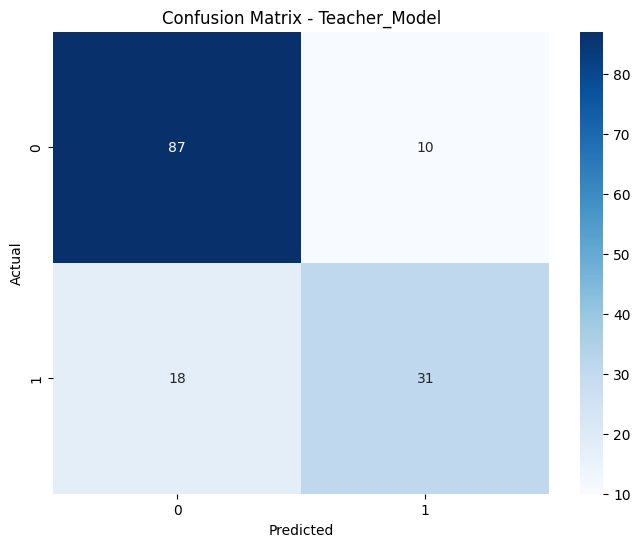

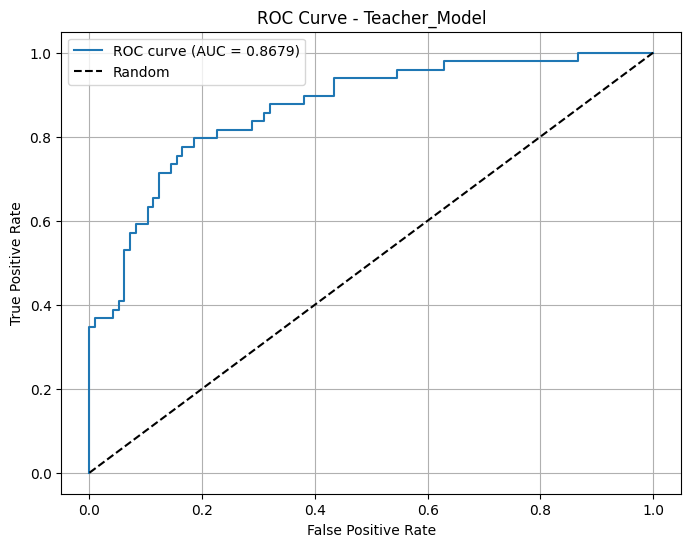

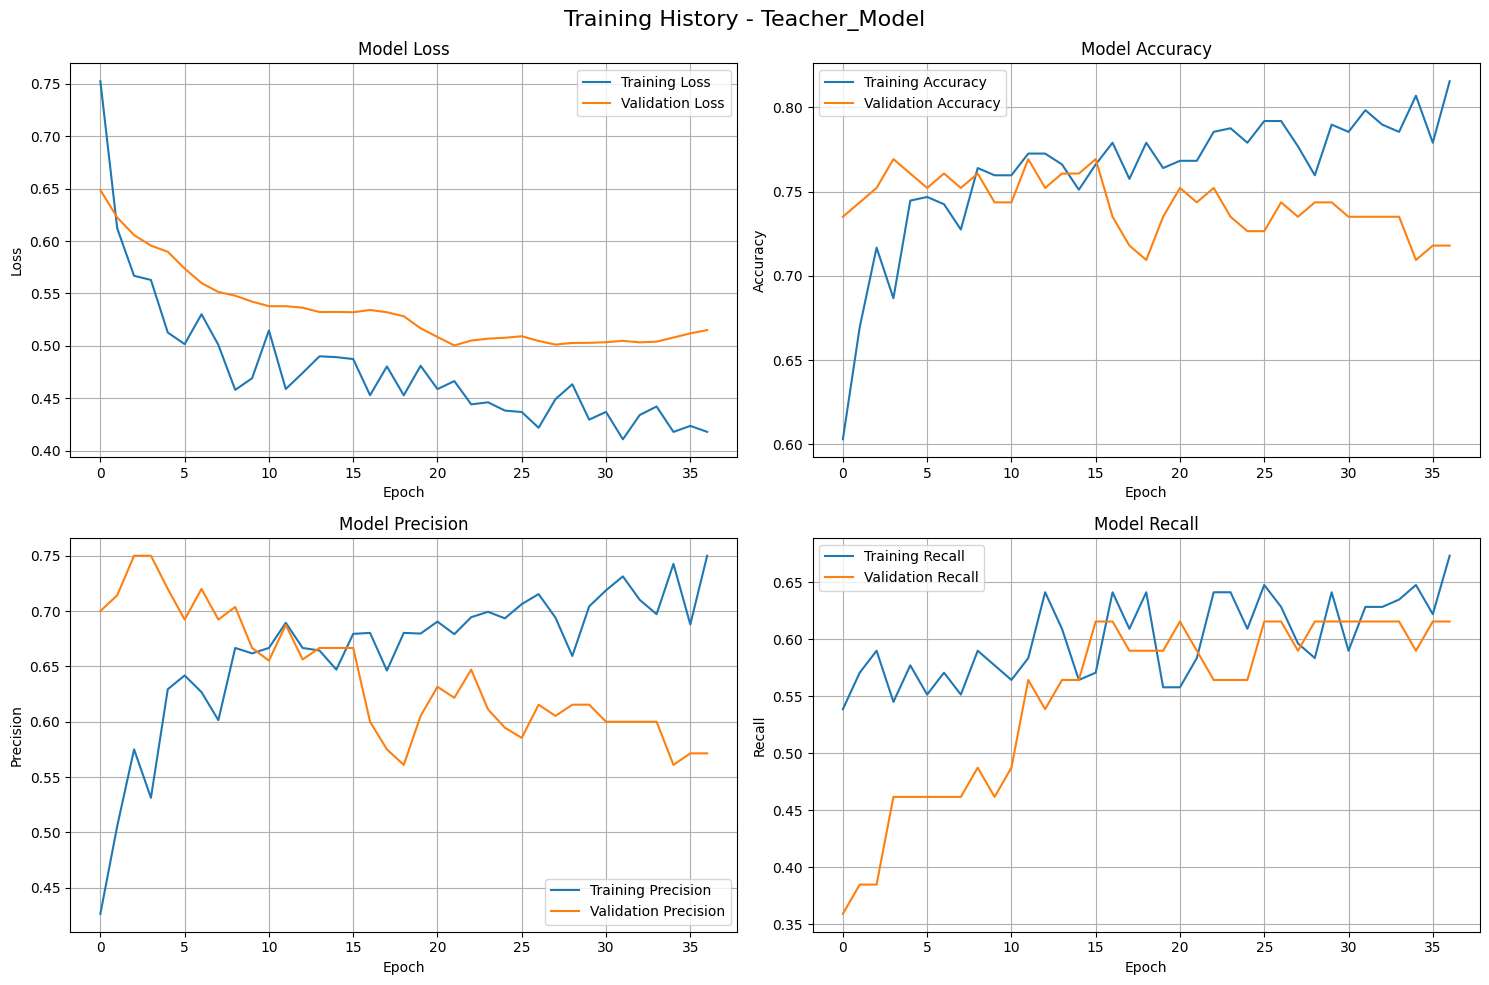

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Evaluation Results for Student_Distillation
Accuracy:  0.7877
Precision: 0.7368
Recall:    0.5714
F1 Score:  0.6437
ROC AUC:   0.8700

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        97
         1.0       0.74      0.57      0.64        49

    accuracy                           0.79       146
   macro avg       0.77      0.73      0.75       146
weighted avg       0.78      0.79      0.78       146



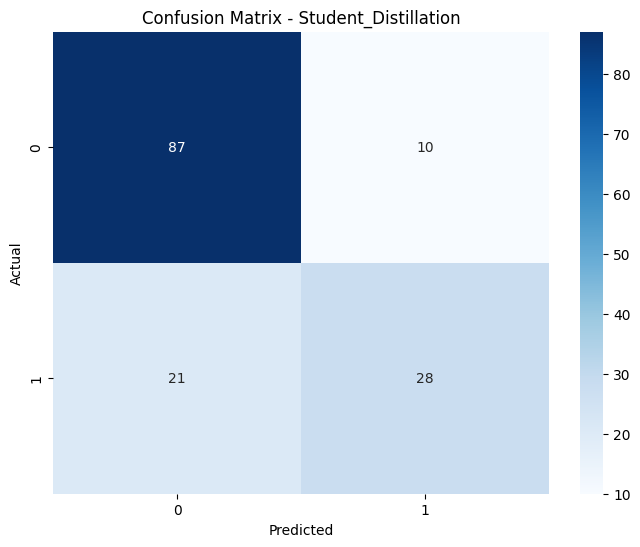

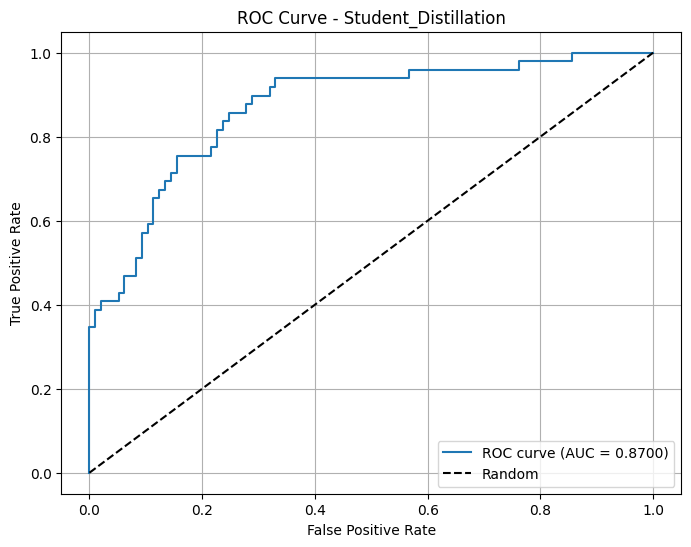

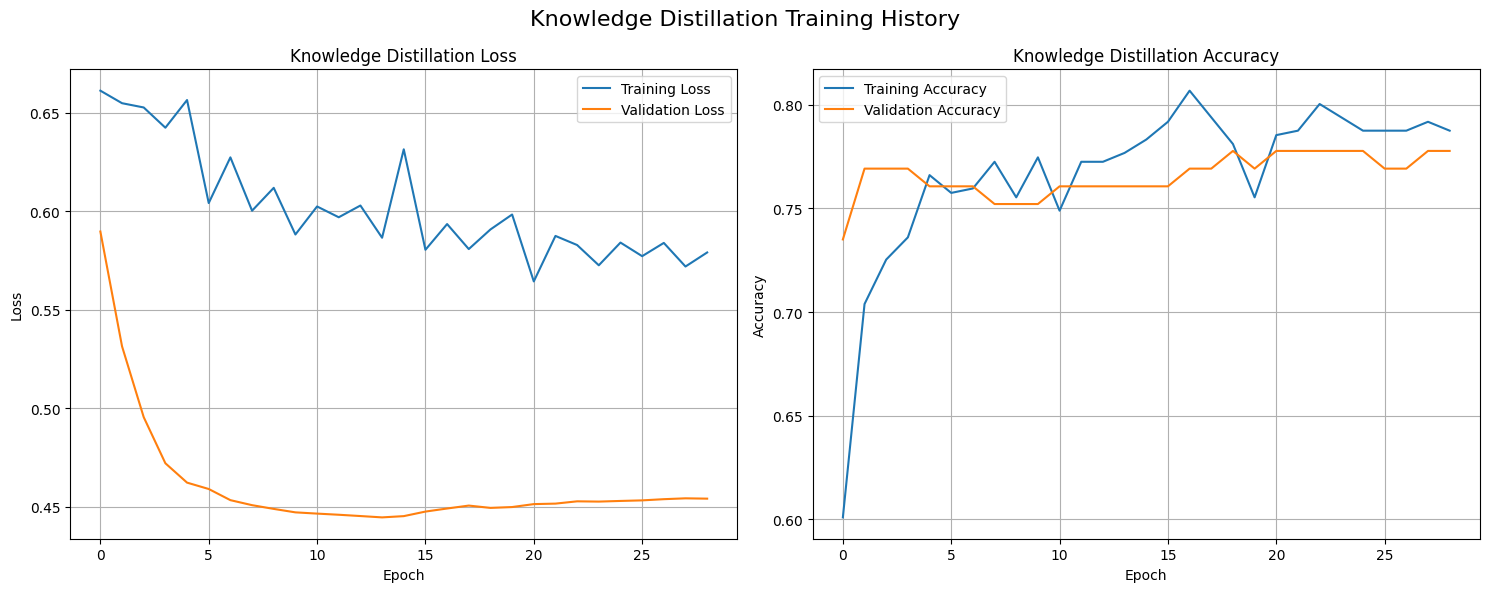

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Evaluation Results for Fine_Tuned
Accuracy:  0.8425
Precision: 0.8611
Recall:    0.6327
F1 Score:  0.7294
ROC AUC:   0.8828

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89        97
         1.0       0.86      0.63      0.73        49

    accuracy                           0.84       146
   macro avg       0.85      0.79      0.81       146
weighted avg       0.84      0.84      0.84       146



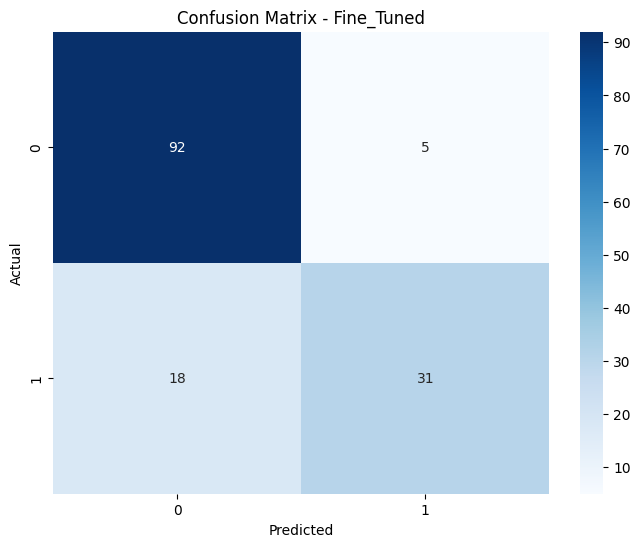

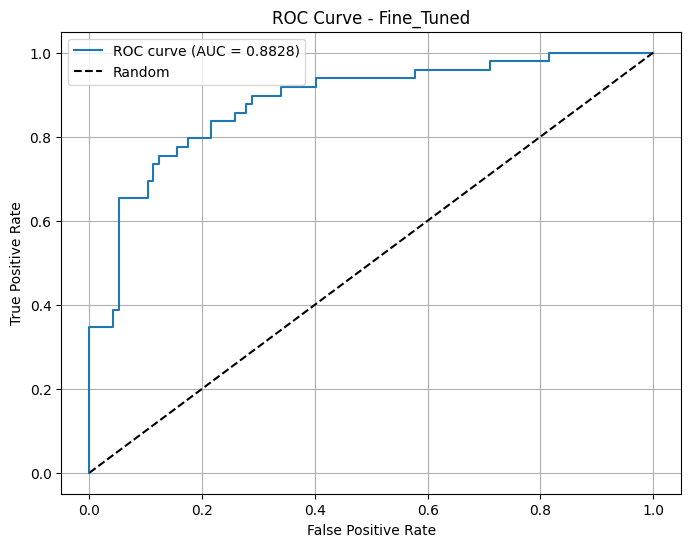

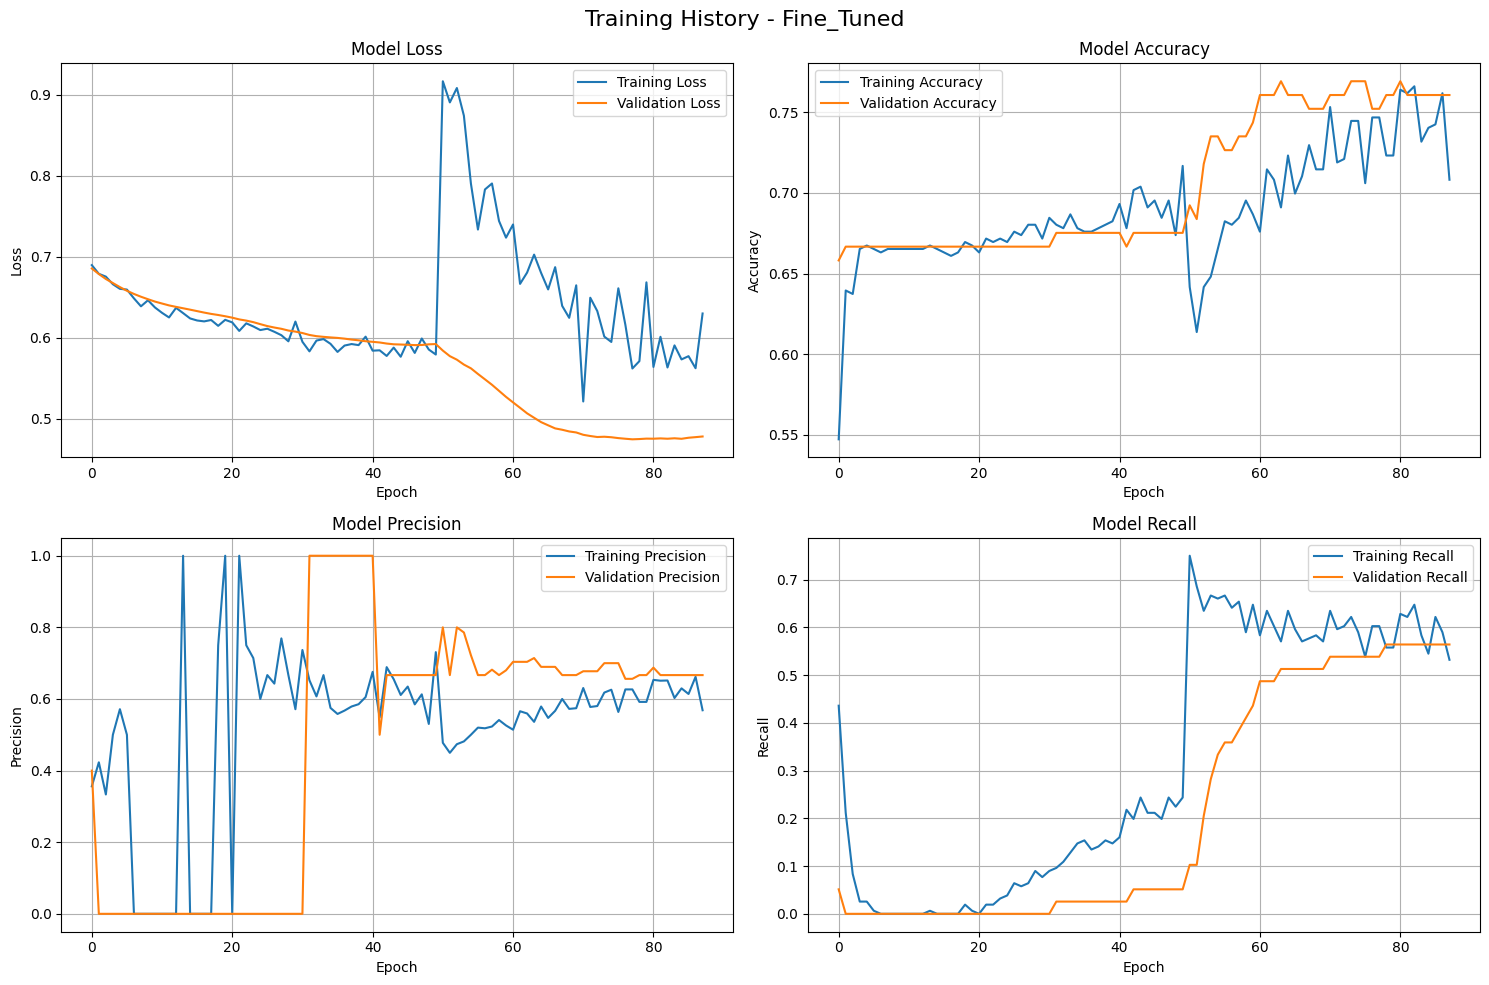

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Evaluation Results for Multi_Task
Accuracy:  0.7945
Precision: 0.7317
Recall:    0.6122
F1 Score:  0.6667
ROC AUC:   0.8719

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85        97
         1.0       0.73      0.61      0.67        49

    accuracy                           0.79       146
   macro avg       0.78      0.75      0.76       146
weighted avg       0.79      0.79      0.79       146



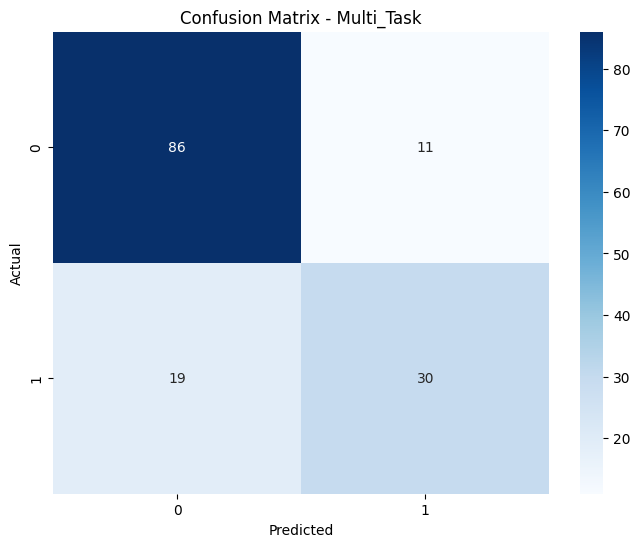

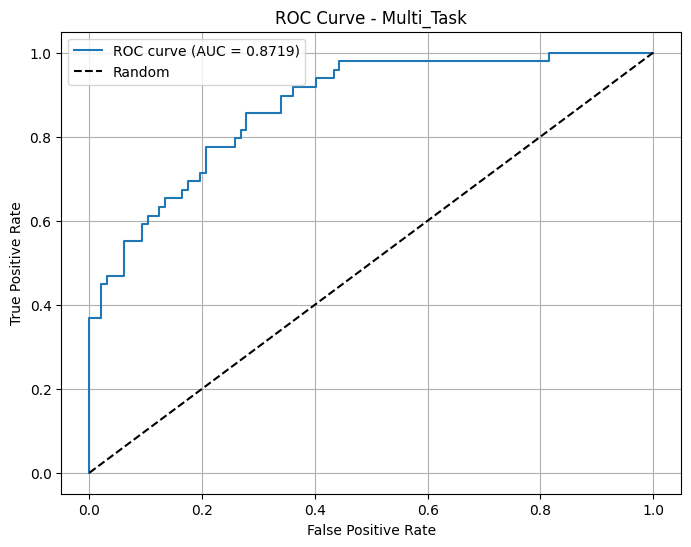

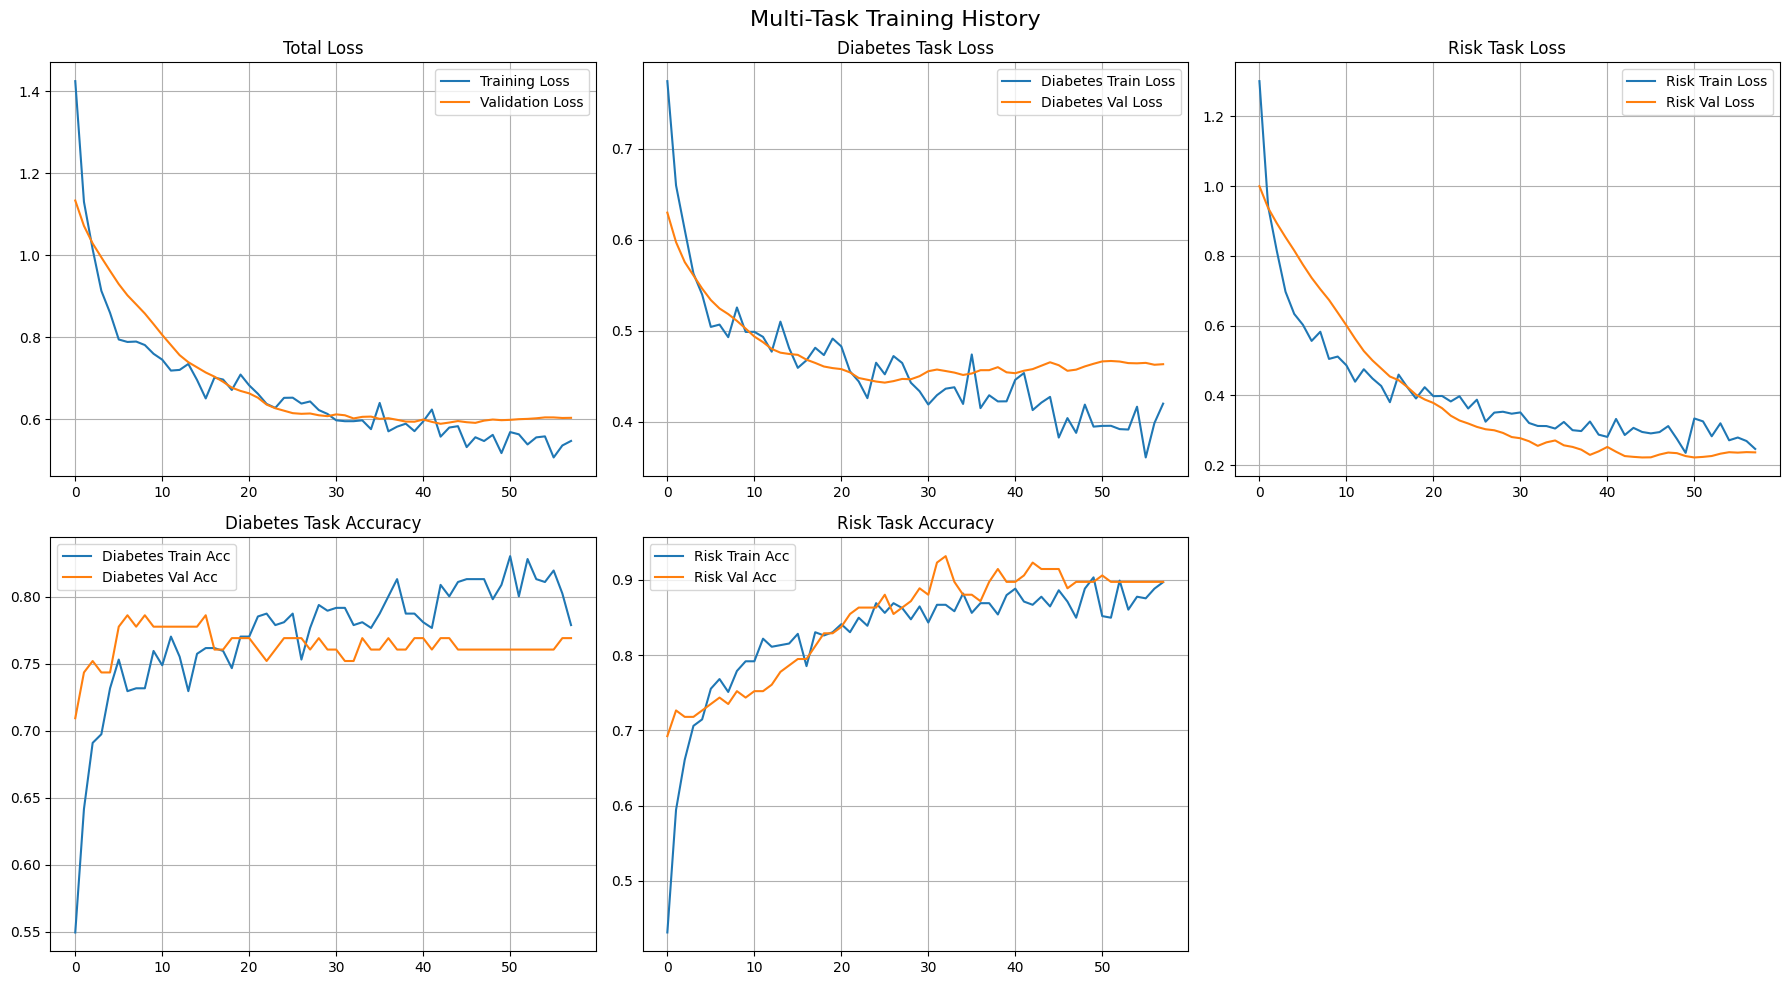


Model Comparison:
                      accuracy  precision    recall        f1   roc_auc
Teacher_Model         0.808219   0.756098  0.632653  0.688889  0.867873
Student_Distillation  0.787671   0.736842  0.571429  0.643678  0.869977
Fine_Tuned            0.842466   0.861111  0.632653  0.729412  0.882811
Multi_Task            0.794521   0.731707  0.612245  0.666667  0.871870


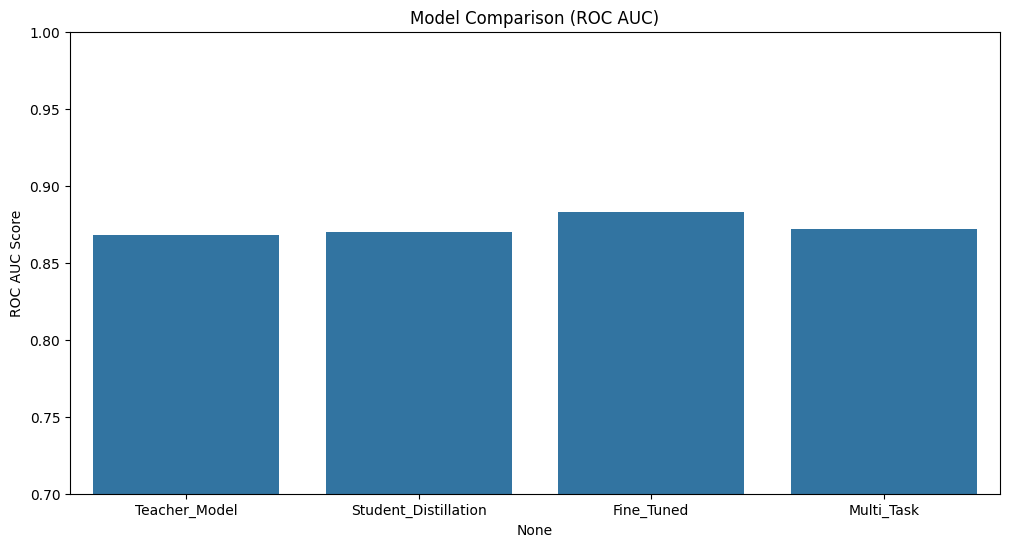

In [65]:
# Initialize the classifier
classifier = DiabetesTransferLearningClassifier()

# Prepare the data
X_train, X_val, X_test, y_train, y_val, y_test = classifier.prepare_data(df_scaled)

# Train different models
teacher_model = classifier.train_teacher_model(X_train, y_train, X_val, y_val, epochs=100)
student_model = classifier.train_student_with_distillation(X_train, y_train, X_val, y_val, teacher_model, epochs=100)
fine_tuned_model = classifier.train_fine_tuned_model(X_train, y_train, X_val, y_val, teacher_model, epochs=100)
multi_task_model = classifier.train_multi_task_model(X_train, y_train, X_val, y_val, epochs=100)

# Evaluate all models
models_to_evaluate = {
    'Teacher_Model': teacher_model,
    'Student_Distillation': student_model,
    'Fine_Tuned': fine_tuned_model,
    'Multi_Task': multi_task_model
}

results = {}
for name, model in models_to_evaluate.items():
    results[name] = classifier.evaluate_model(model, name, X_test, y_test)
    classifier.plot_training_history(name)

# Compare model performances
print("\nModel Comparison:")
comparison_df = pd.DataFrame(results).T
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(x=comparison_df.index, y='roc_auc', data=comparison_df)
plt.title('Model Comparison (ROC AUC)')
plt.ylabel('ROC AUC Score')
plt.ylim(0.7, 1.0)
plt.show()

## Referensi
1. American Diabetes Association. (2020). Standards of Medical Care in Diabetes.
2. World Health Organization. (2020). Global Report on Diabetes.
3. Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. Proceedings of the Annual Symposium on Computer Application in Medical Care, 261-265.
4. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.